# Check atm parameters

In [106]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np
import os,sys
import re
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import itertools

from astropy import units as u
from astropy.coordinates import Angle

import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [107]:
from astropy.io import fits

In [108]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [109]:
os.getenv('LIBRADTRANDIR')

'/Users/dagoret/MacOSX/External/libRadtran2'

In [110]:
sys.path.append('../libradtran')

In [111]:
import libsimulateVisible

In [112]:
def GetPacket(packetnum,packetsize,data):
    """
    """
    nrowmin = int((packetnum - 1) * packetsize)
    nrowmax = int((packetnum) * packetsize - 1)
    MAXYSIZE=data.shape[0]
    MAXINDEX=min(nrowmax,MAXYSIZE)
    MININDEX=min(nrowmin,MAXYSIZE)
    
    return MININDEX,MAXINDEX,data[MININDEX:MAXINDEX+1,:]
    

# Initialisation

In [113]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)


#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))



LA time: 09:28:04
NY time: 12:28:04
London time: 17:28:04
Paris time: 18:28:04


In [114]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [115]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""
   

In [116]:
msg = f"Start {parser.prog} at date : {string_date} and time :{current_time} and with arguments:{results_args}"
logger.info(msg)

2020-09-14 18:28:04,382 MacBook-Pro-de-admin.local __main__[45645] INFO Start ipykernel_launcher.py at date : 2020-09-14 and time :18:28:04 and with arguments:


# Configuration

In [117]:
# config file
# --------------
configfile = "config/default.ini"
packetnum =100
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)

2020-09-14 18:28:04,389 MacBook-Pro-de-admin.local __main__[45645] INFO Configuration file : config/default.ini


In [118]:
packet_str=str(packetnum).zfill(4)

In [119]:
packet_str

'0100'

In [120]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2020-09-14 18:28:04,406 MacBook-Pro-de-admin.local __main__[45645] INFO 1) Configuration


In [121]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)    

In [122]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT = bool(int(config['GENERAL']['FLAG_PRINT']))
else:
    msg = f"empty section GENERAL in config file {config_filename} !"
    logger.error(msg)


if 'SIMTRANSPARENCY'in config_section:
    input_file = config['SIMTRANSPARENCY']['inputfile']
    input_dir = config['SIMTRANSPARENCY']['inputdir']

    output_file = config['SIMTRANSPARENCY']['outputfile']
    output_dir = config['SIMTRANSPARENCY']['outputdir']

    packetsize = int(config['SIMTRANSPARENCY']['packetsize'])

output_file_split=output_file.split(".")    
output_file=output_file_split[0]+"_"+packet_str+"."+output_file_split[1]    
    
full_inputfilename=os.path.join(input_dir,input_file)
full_outputfilename=os.path.join(output_dir,output_file)

In [123]:
msg = f"FLAG_PLOT = {FLAG_PLOT}"
logger.info(msg)

msg = f"FLAG_VERBOSE = {FLAG_VERBOSE}"
logger.info(msg)

msg=f"input file name = {full_inputfilename}"
logger.info(msg)

msg=f"output file name = {full_outputfilename}"
logger.info(msg)

# range inside the atmospheric parameter file
NROWMIN = (packetnum - 1) * packetsize
NROWMAX = (packetnum) * packetsize - 1

msg = f"NROWMIN = {NROWMIN} , NROWMAX  = {NROWMAX}  "
logger.info(msg)

2020-09-14 18:28:04,433 MacBook-Pro-de-admin.local __main__[45645] INFO FLAG_PLOT = False
2020-09-14 18:28:04,434 MacBook-Pro-de-admin.local __main__[45645] INFO FLAG_VERBOSE = False
2020-09-14 18:28:04,435 MacBook-Pro-de-admin.local __main__[45645] INFO input file name = atmsimdata/atmparam.fits
2020-09-14 18:28:04,435 MacBook-Pro-de-admin.local __main__[45645] INFO output file name = atmsimdata/atmtransparency_0100.fits
2020-09-14 18:28:04,436 MacBook-Pro-de-admin.local __main__[45645] INFO NROWMIN = 9900 , NROWMAX  = 9999  


# open input atmospheric parameters

In [124]:
hduin = fits.open(full_inputfilename)

In [125]:
msg = "{}".format(hduin.info())
logger.info(msg)

Filename: atmsimdata/atmparam.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   (6, 20000)   float64   


2020-09-14 18:28:04,494 MacBook-Pro-de-admin.local __main__[45645] INFO None


In [126]:
headerin=hduin[0].header
datain=hduin[0].data

In [127]:
NSIM=len(datain)

In [128]:
if NROWMIN>NSIM:
    msg = f" >>> NROWMIN = {NROWMIN} greater than  NSIM={NSIM} ==> stop simulation"
    logger.error(msg)

In [129]:
logger.info(headerin)

2020-09-14 18:28:04,532 MacBook-Pro-de-admin.local __main__[45645] INFO SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                    6                                                  NAXIS2  =                20000                                                  NBATMSIM=                20000                                                  ID_NUM  =                    0                                                  ID_AM   =                    1                                                  ID_VAOD =                    2                                                  ID_PWV  =                    3                                                  ID_O3   =                    4                                                  ID_CLD  =                    5                  

In [130]:
logger.info(datain[0,:])

2020-09-14 18:28:04,543 MacBook-Pro-de-admin.local __main__[45645] INFO [1.00000000e+00 1.53220012e+00 9.36695493e-03 8.52227912e+00
 3.05909111e+02 4.15755819e-01]


In [131]:
hdr=headerin
NSIMH=hdr['NBATMSIM']
idx_num = hdr['ID_NUM']
idx_am = hdr['ID_AM']
idx_vaod=hdr['ID_VAOD']
idx_pwv= hdr['ID_PWV']
idx_o3=hdr['ID_O3']
idx_cld=hdr['ID_CLD']
idx_res= hdr['ID_RES']

In [132]:
Nbpacket=int(NSIMH/packetsize)

In [133]:
NSIM

20000

In [134]:
Nbpacket

200

# Check

In [135]:
all_data=[]

for ipacket in np.arange(1,Nbpacket+1):
    irowmin,irowmax,data=GetPacket(ipacket,packetsize,datain)
    all_data.append(data)
    msg = f" >>> NROWMIN = {irowmin} - NROWMAX = {irowmax}"
    logger.error(msg)

2020-09-14 18:28:04,609 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 0 - NROWMAX = 99
2020-09-14 18:28:04,610 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 100 - NROWMAX = 199
2020-09-14 18:28:04,612 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 200 - NROWMAX = 299
2020-09-14 18:28:04,613 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 300 - NROWMAX = 399
2020-09-14 18:28:04,613 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 400 - NROWMAX = 499
2020-09-14 18:28:04,614 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 500 - NROWMAX = 599
2020-09-14 18:28:04,615 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 600 - NROWMAX = 699
2020-09-14 18:28:04,615 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 700 - NROWMAX = 799
2020-09-14 18:28:04,616 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 800 - NROWMAX = 899
2020-09-14 18:28:04,616 MacBook

2020-09-14 18:28:04,692 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 7500 - NROWMAX = 7599
2020-09-14 18:28:04,695 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 7600 - NROWMAX = 7699
2020-09-14 18:28:04,701 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 7700 - NROWMAX = 7799
2020-09-14 18:28:04,707 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 7800 - NROWMAX = 7899
2020-09-14 18:28:04,708 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 7900 - NROWMAX = 7999
2020-09-14 18:28:04,709 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 8000 - NROWMAX = 8099
2020-09-14 18:28:04,709 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 8100 - NROWMAX = 8199
2020-09-14 18:28:04,710 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 8200 - NROWMAX = 8299
2020-09-14 18:28:04,711 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 8300 - NROWMAX = 8399
2020-09-14

2020-09-14 18:28:04,790 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 14900 - NROWMAX = 14999
2020-09-14 18:28:04,791 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 15000 - NROWMAX = 15099
2020-09-14 18:28:04,791 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 15100 - NROWMAX = 15199
2020-09-14 18:28:04,792 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 15200 - NROWMAX = 15299
2020-09-14 18:28:04,795 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 15300 - NROWMAX = 15399
2020-09-14 18:28:04,796 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 15400 - NROWMAX = 15499
2020-09-14 18:28:04,797 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 15500 - NROWMAX = 15599
2020-09-14 18:28:04,798 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 15600 - NROWMAX = 15699
2020-09-14 18:28:04,800 MacBook-Pro-de-admin.local __main__[45645] ERROR  >>> NROWMIN = 15700 - NROWMAX 

In [139]:
all_am=np.zeros(Nbpacket)
all_pwv=np.zeros(Nbpacket)
all_aer=np.zeros(Nbpacket)
all_o3=np.zeros(Nbpacket)
all_cld=np.zeros(Nbpacket)

idx=0 
    
for ipacket in np.arange(Nbpacket):    
   
    am=all_data[ipacket][idx,idx_am]
    pwv=all_data[ipacket][idx,idx_pwv]
    ozone=all_data[ipacket][idx,idx_o3]
    aer=all_data[ipacket][idx,idx_vaod]
    pressure=0
    cloudext=all_data[ipacket][idx,idx_cld]
    
    all_z[ipacket]=am
    all_pwv[ipacket]=pwv
    all_aer[ipacket]=aer
    all_o3[ipacket]=ozone
    all_cld[ipacket]=cloudext
    

Text(0.5, 0, 'od')

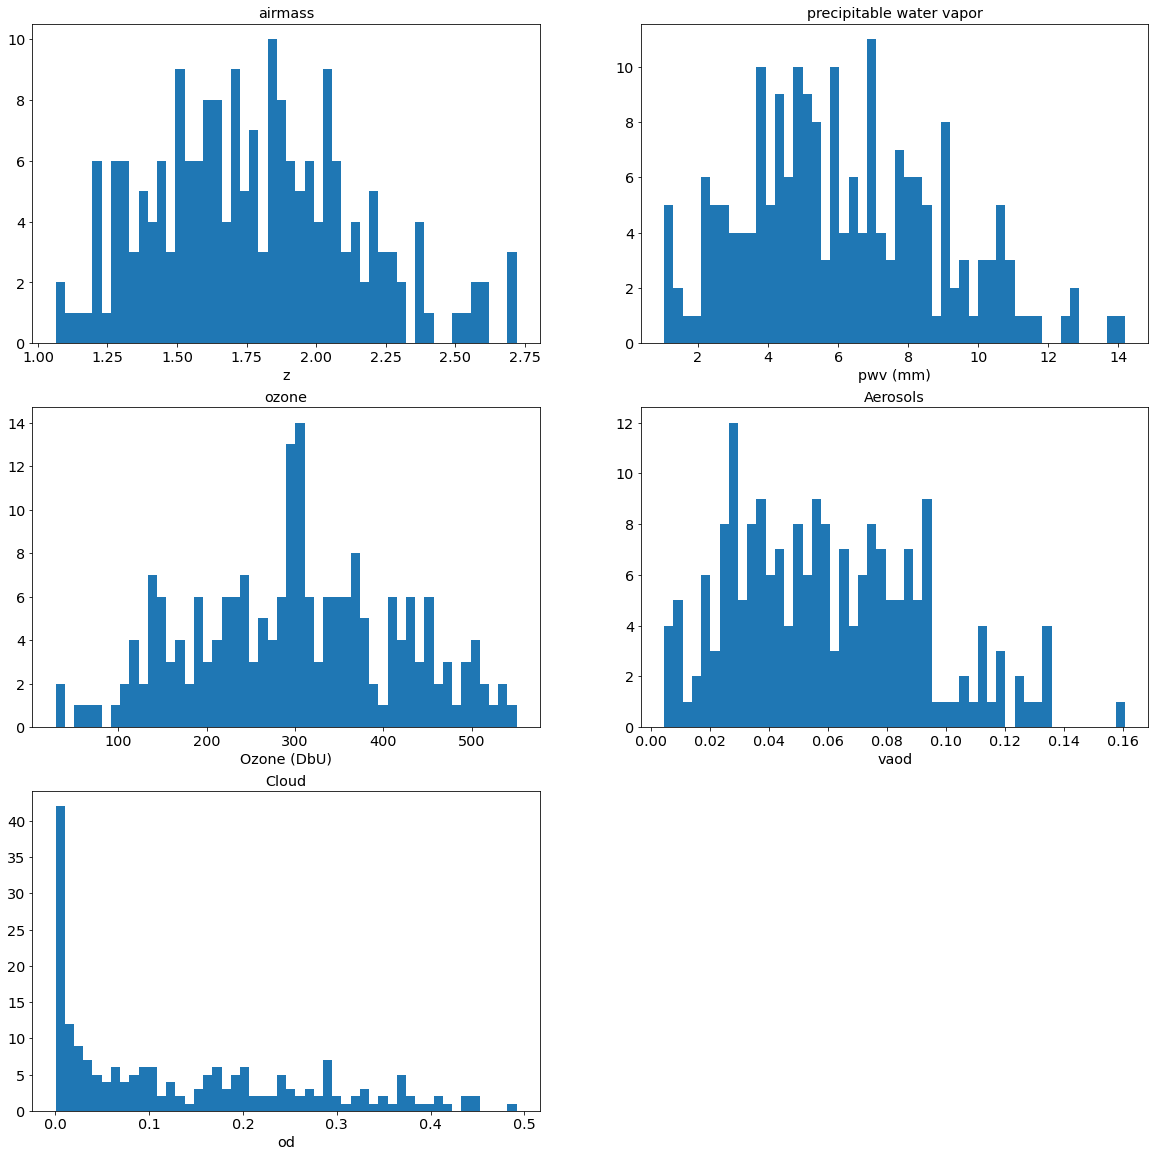

In [140]:
fig=plt.figure(figsize=(20,20))
ax1=fig.add_subplot(321)
ax1.hist(all_z,bins=50);
ax1.set_title("airmass")
ax1.set_xlabel("z")

ax2=fig.add_subplot(322)
ax2.hist(all_pwv,bins=50);
ax2.set_title("precipitable water vapor")
ax2.set_xlabel("pwv (mm)")

ax3=fig.add_subplot(323)
ax3.hist(all_o3,bins=50);
ax3.set_title("ozone")
ax3.set_xlabel("Ozone (DbU)")
    
ax4=fig.add_subplot(324)
ax4.hist(all_aer,bins=50);
ax4.set_title("Aerosols")
ax4.set_xlabel("vaod")
    
ax5=fig.add_subplot(325)
ax5.hist(all_cld,bins=50);
ax5.set_title("Cloud")
ax5.set_xlabel("od")


In [141]:
N=Nbpacket
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

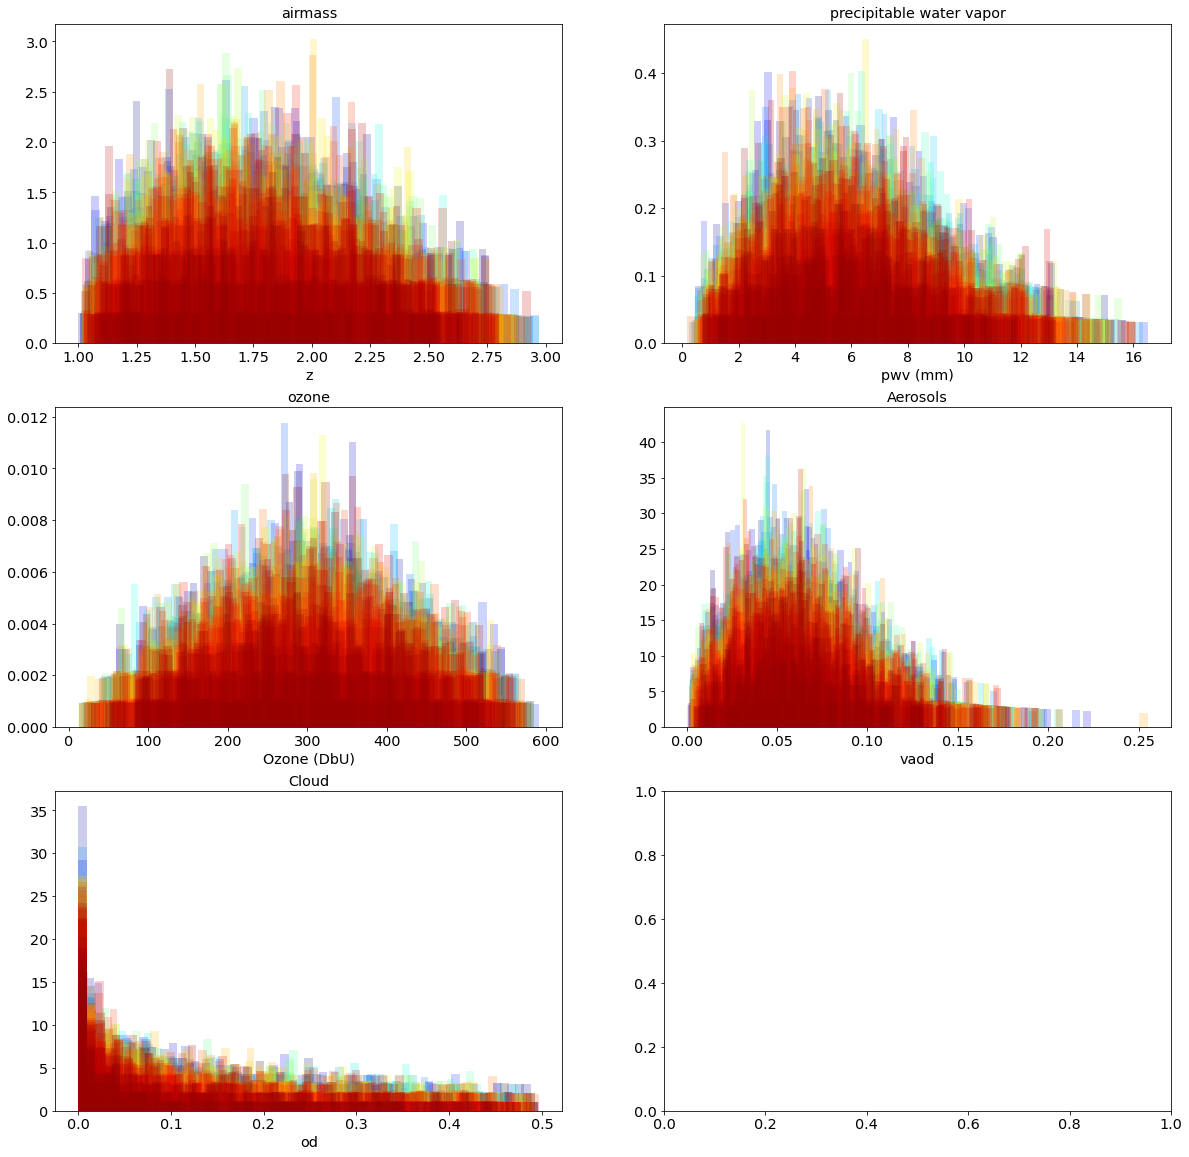

In [142]:
fig=plt.figure(figsize=(20,20))
ax1=fig.add_subplot(321)
ax2=fig.add_subplot(322)
ax3=fig.add_subplot(323)
ax4=fig.add_subplot(324)
ax5=fig.add_subplot(325)
ax6=fig.add_subplot(326)


for ipacket in np.arange(Nbpacket):    
   
    am=all_data[ipacket][:,idx_am]
    pwv=all_data[ipacket][:,idx_pwv]
    ozone=all_data[ipacket][:,idx_o3]
    aer=all_data[ipacket][:,idx_vaod]
    cloudext=all_data[ipacket][:,idx_cld]
    
    ax1.hist(am,bins=50,facecolor=all_colors[ipacket],alpha=0.2,density=True);
    ax1.set_title("airmass")
    ax1.set_xlabel("z")
    ax2.hist(pwv,bins=50,facecolor=all_colors[ipacket],alpha=0.2,density=True);
    ax2.set_title("precipitable water vapor")
    ax2.set_xlabel("pwv (mm)")
    ax3.hist(ozone,bins=50,facecolor=all_colors[ipacket],alpha=0.2,density=True);
    ax3.set_title("ozone")
    ax3.set_xlabel("Ozone (DbU)")
    ax4.hist(aer,bins=50,facecolor=all_colors[ipacket],alpha=0.2,density=True);
    ax4.set_title("Aerosols")
    ax4.set_xlabel("vaod")
    ax5.hist(cloudext,bins=50,facecolor=all_colors[ipacket],alpha=0.2,density=True);
    ax5.set_title("Cloud")
    ax5.set_xlabel("od")